Link to the notebook: https://tinyurl.com/y2zz2qu8
**Copy the notebook to your GDrive to edit.**

# Setup

In [1]:
# magic commands to make sure changes to external packages are automatically loaded and plots are displayed in the notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip3 install datasets transformers bpemb

     |████████████████████████████████| 270 kB 5.4 MB/s 
     |████████████████████████████████| 2.8 MB 26.3 MB/s 
     |████████████████████████████████| 243 kB 46.0 MB/s 
     |████████████████████████████████| 1.3 MB 32.9 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 123 kB 49.8 MB/s 
     |████████████████████████████████| 895 kB 36.1 MB/s 
     |████████████████████████████████| 3.3 MB 38.0 MB/s 
     |████████████████████████████████| 636 kB 29.6 MB/s 
     |████████████████████████████████| 1.2 MB 44.4 MB/s 
     |████████████████████████████████| 294 kB 42.2 MB/s 
     |████████████████████████████████| 142 kB 45.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import torch
import random
import numpy as np
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm
from torch.optim import Adam, RMSprop
import nltk
from datasets import load_dataset
from bpemb import BPEmb

In [4]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

In [5]:
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")
device

device(type='cuda')

# Language Models

![LM example](https://lh5.googleusercontent.com/K6L6kme_QmdPic_mP5QusvB0sq_Cy8fxfzIJCqoATS_li6ct5VyZ6E7AZT_UINact-6tbUavVtLdvaAufzVMxureqfX9GNpXofEOwasd5giVOLLiPcX9nZ8YUq6mQ0gb6Y8_9lSPtQGwm0ZnEQ)


* Trained to predict probabilities of the **next word, given some context**. 
* Architectures with **large numbers** of parameters trained on large corpora of text.
* Can be used to generate text, to verify how likely is a particular sequence of text, e.g. if it sounds grammatical and complies to the rules of a language, or we can use the contextual representations of the words learned by the model. 
* Evaluated with **perplexity**, which is the inverse probability of the test set, normalized by the number of words:

\begin{equation}
\mathrm{PP}(W)=\sqrt[N]{\prod_{i=1}^{N} \frac{1}{P\left(w_{i} \mid w_{1} \ldots w_{i-1}\right)}}
\end{equation}
* Equivalent to the **exponential of the cross-entropy loss** [(detailed explanation)](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94)
* Minimizing perplexity is the same as maximising probability of the correct prediction. 
* Low perplexity is better!



# RNNs

## Recap

![Karpathy blog rnn example](https://karpathy.github.io/assets/rnn/diags.jpeg)

Source: https://karpathy.github.io/2015/05/21/rnn-effectiveness/

* Widely used for working with sequence data. 
* Can be used for a variety of problems which work with sequences.
* Consider both a given input and a **state**, which is updated at every step on the input sequence. 
* How this state is kept and the internal calculations of an RNN can differ.   
  * Three main types of RNN cells: vanilla RNNs, GRU, and LSTM. 
  * GRUs and LSTMs differ from vanilla RNNs in that they use **gating mechanisms** to mitigate vanishing gradients, and are better at capturing long-term dependencies.

## Data Preparation for RNNs
*PyTorch-specific.

### Packing

In [6]:
# We want to run LSTM on a batch with 3 sentences
sents = ['The word of the Lord came to Zechariah son of Iddo the prophet.',  # len = 13
        'fruit flies like a banana',      # len = 5
        'Fruit flies live on a banana']    # len = 6

# Step 1: Construct Vocabulary
vocab = ['<pad>'] + sorted(set([token for sent in sents for token in sent.split()]))

#Step 2: Load indexed data (list of instances, where each instance is list of character indices)
vectorized_seqs = [[vocab.index(tok) for tok in sent.split()]for sent in sents]

#Step 3: Make Model
embed = torch.nn.Embedding(len(vocab), 4) # embedding_dim = 4
lstm = torch.nn.LSTM(input_size=4, hidden_size=5, batch_first=True) # input_dim = 4, hidden_dim = 5

#Step 4: Pad instances with 0s till max length sequence
# get the length of each seq in your batch
seq_lengths = torch.LongTensor(list(map(len, vectorized_seqs)))

seq_tensor = torch.tensor(torch.zeros((len(vectorized_seqs), seq_lengths.max()))).long()

for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
    seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
seq_tensor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[ 4, 19, 13, 17,  3,  8, 18,  5, 16, 13,  2, 17, 15],
        [10,  9, 11,  6,  7,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  9, 12, 14,  6,  7,  0,  0,  0,  0,  0,  0,  0]])

In [7]:
# Step 5: Sort instances by sequence length in descending order 
# this step is not compulsory, where the packing functions have a parameter enforce_sorted, which can be set to False
seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
seq_tensor = seq_tensor[perm_idx]
seq_tensor

tensor([[ 4, 19, 13, 17,  3,  8, 18,  5, 16, 13,  2, 17, 15],
        [ 1,  9, 12, 14,  6,  7,  0,  0,  0,  0,  0,  0,  0],
        [10,  9, 11,  6,  7,  0,  0,  0,  0,  0,  0,  0,  0]])

In [8]:
# Calling pack_padded_sequence with instances and sequence lengths
# Packing is important for training RNN on text with variable lenght
packed_input = torch.nn.utils.rnn.pack_padded_sequence(seq_tensor, seq_lengths.cpu().numpy(), batch_first=True)
# packed_input (PackedSequence is NamedTuple with 2 attributes: data and batch_sizes
packed_input

PackedSequence(data=tensor([ 4,  1, 10, 19,  9,  9, 13, 12, 11, 17, 14,  6,  3,  6,  7,  8,  7, 18,
         5, 16, 13,  2, 17, 15]), batch_sizes=tensor([3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [9]:
# Step 6: Let's now proceed with the network transformations and embed the instances
embedded_seq_tensor = embed(seq_tensor)
embedded_seq_tensor

tensor([[[ 1.6423, -0.1596, -0.4974,  0.4396],
         [ 0.5750, -0.6417, -2.2064, -0.7508],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [ 0.3466, -0.1973, -1.0546,  1.2780],
         [-0.7279, -0.5594, -0.7688,  0.7624],
         [-1.3847, -0.8712, -0.2234,  1.7174],
         [-0.1722,  0.5238,  0.0566,  0.4263],
         [-0.7581,  1.0783,  0.8008,  1.6806],
         [ 1.4451,  0.8564,  2.2181,  0.5232],
         [-0.4880,  1.1914, -0.8140, -0.7360],
         [-0.7521,  1.6487, -0.3925, -1.4036],
         [ 0.3466, -0.1973, -1.0546,  1.2780],
         [-0.0978,  1.8446, -1.1845,  1.3835]],

        [[ 0.6784, -1.2345, -0.0431, -1.6047],
         [ 0.3189, -0.4245,  0.3057, -0.7746],
         [-0.9138, -0.6581,  0.0780,  0.5258],
         [-1.4032,  0.0360, -0.0635,  0.6756],
         [ 1.2791,  1.2964,  0.6105,  1.3347],
         [-0.2316,  0.0418, -0.2516,  0.8599],
         [ 1.9269,  1.4873,  0.9007, -2.1055],
         [ 1.9269,  1.4873,  0.9007, -2.1055],
         [ 

In [10]:
# Step 7: Call pack_padded_sequence with embeded instances and sequence lengths
packed_input = torch.nn.utils.rnn.pack_padded_sequence(embedded_seq_tensor, seq_lengths.cpu().numpy(), batch_first=True)
# packed_input (PackedSequence is NamedTuple with 2 attributes: data and batch_sizes
packed_input

PackedSequence(data=tensor([[ 1.6423, -0.1596, -0.4974,  0.4396],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-1.5576,  0.9956, -0.8798, -0.6011],
        [ 0.5750, -0.6417, -2.2064, -0.7508],
        [ 0.3189, -0.4245,  0.3057, -0.7746],
        [ 0.3189, -0.4245,  0.3057, -0.7746],
        [-0.4880,  1.1914, -0.8140, -0.7360],
        [-0.9138, -0.6581,  0.0780,  0.5258],
        [-1.2742,  2.1228, -1.2347, -0.4879],
        [ 0.3466, -0.1973, -1.0546,  1.2780],
        [-1.4032,  0.0360, -0.0635,  0.6756],
        [ 1.2791,  1.2964,  0.6105,  1.3347],
        [-0.7279, -0.5594, -0.7688,  0.7624],
        [ 1.2791,  1.2964,  0.6105,  1.3347],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [-1.3847, -0.8712, -0.2234,  1.7174],
        [-0.2316,  0.0418, -0.2516,  0.8599],
        [-0.1722,  0.5238,  0.0566,  0.4263],
        [-0.7581,  1.0783,  0.8008,  1.6806],
        [ 1.4451,  0.8564,  2.2181,  0.5232],
        [-0.4880,  1.1914, -0.8140, -0.7360],
        [-0.75

In [11]:
# Step 8: Forward with LSTM
packed_output, (ht, ct) = lstm(packed_input)

# Step 9: Call unpack_padded_sequences if required / or just pick last hidden vector
output, input_sizes = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

Summary of Shape Transformations

(batch_size X max_seq_len X embedding_dim) --> Sort by seqlen ---> (batch_size X max_seq_len X embedding_dim)

(batch_size X max_seq_len X embedding_dim) --->      Pack     ---> (batch_sum_seq_len X embedding_dim)

(batch_sum_seq_len X embedding_dim)        --->      LSTM     ---> (batch_sum_seq_len X hidden_dim)

(batch_sum_seq_len X hidden_dim)           --->    UnPack     ---> (batch_size X max_seq_len X hidden_dim)


### Bucketing
* Group instances of *similar* lenghts in the same batch which leads to minimal padding. 
* E.g. a batch with instances of lenght 5, 5, 6 will be padded to lenght 6, while a batch with instances of lenght 5, 5, 13 will be padded to lenght 13 and will also take more time for processing.
* To still have some randomness in the batches, we usually have buckets with N instances with similar lenght and shuffle them into K batches.
* Example implementation -- Bucket Iterator (https://torchtext.readthedocs.io/en/latest/data.html#bucketiterator).

## Dataset Loading

For training the Language Model, we'll be using the [WikiText-2 dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)

HuggingFace have a [repository](https://huggingface.co/datasets) of many datasets, where you can easily find datasets of interests (e.g. the TyDi QA dataset).


In [6]:
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')
datasets.keys()

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/aa5e094000ec7afeb74c3be92c88313cd6f132d564c7effd961c10fd47c76f20. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

dict_keys(['test', 'train', 'validation'])

In [7]:
print(datasets['train'][1])
print(datasets['train'][2])
print(datasets['train'][3])

{'text': ' = Valkyria Chronicles III = \n'}
{'text': ''}
{'text': ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n'}


In [8]:
# We'll use again the pretrained BP Embeddings and the corresponding tokenizer.

bpemb_en = BPEmb(lang='en', dim=100, vs=25000)
# Extract the embeddings and add a randomly initialized embedding for our extra [PAD] token
pretrained_embeddings = np.concatenate([bpemb_en.emb.vectors, np.zeros(shape=(1,100))], axis=0)
# Extract the vocab and add an extra [PAD] token
vocabulary = bpemb_en.emb.index2word + ['[PAD]']

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.model


100%|██████████| 661443/661443 [00:00<00:00, 1232637.82B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9477142/9477142 [00:01<00:00, 7995011.64B/s] 


In [9]:
def tokenizer(text):
  return {'input_ids': bpemb_en.encode_ids_with_eos(text)}

def tokenize_function(examples):
    return tokenizer(examples['text'])

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of size block_size .
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    return result

block_size = 128

tokenized_datasets = datasets.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])
print(tokenized_datasets['train'][3]['input_ids'][:10])

lm_datasets = tokenized_datasets.map(group_texts, batched=True, batch_size=1000, num_proc=4,)

[1282, 20611, 467, 852, 2358, 2538, 121, 944, 118, 14849]


In [10]:
def collate_batch_bilstm(dataset) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_ids: The token input ids
    :return: A tuple of tensors (input_ids, targets)
    """
    input_ids = [i['input_ids'] for i in dataset]

    input_lengths, padded_input = [], []
    for sentence in input_ids:
      sentence = sentence[:seq_len]
      input_lengths.append(len(sentence) - 1)
      sentence = sentence + [0] * (seq_len - len(sentence))
      padded_input.append(sentence)

    input_data = torch.tensor(padded_input)

    # we don't use the last position as there isn't anything left for generation
    input_ids = input_data[:, :-1]

    # the target at each step is to generate the next word from the sequence
    # so we shift the token ids with 1 position
    targets = input_data[:, 1:].reshape(-1)

    return input_ids, torch.tensor(input_lengths), targets

In [11]:
test_dl = torch.utils.data.DataLoader(lm_datasets['test'], batch_size=32, collate_fn=collate_batch_bilstm)
train_dl = torch.utils.data.DataLoader(lm_datasets['train'], batch_size=32, collate_fn=collate_batch_bilstm)
valid_dl = torch.utils.data.DataLoader(lm_datasets['validation'], batch_size=32, collate_fn=collate_batch_bilstm)

## Model Implementation

Next we will create an LSTM model. We again extend the PyTorch class `torch.nn.Module` and implement the `__init__` function, and define how tensors are processed in the `__forward__` function.

In [12]:
class LSTM_LM(nn.Module):
    """
    LSTM Language Model
    """
    def __init__(
            self,            
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,       
            dropout_prob: float = 0.0,
            lstm_layers: int = 1,
    ):
        """
        Initializer for LSTM Language Model
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param lstm_layers: The number of stacked LSTM layers
        """

        # First thing is to call the superclass initializer
        super(LSTM_LM, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, an LSTM layer, a dropout layer, and a feed-forward output layer
        self.vocab_size = pretrained_embeddings.shape[0]
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'lstm': nn.LSTM( 
                pretrained_embeddings.shape[1],
                lstm_dim,
                num_layers=lstm_layers,
                batch_first=True,
                dropout=dropout_prob),
            'ff': nn.Linear(lstm_dim, pretrained_embeddings.shape[0]),
            'drop': nn.Dropout(dropout_prob)
        })

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, input_ids, input_lens, hidden_states):
        """
        Defines how tensors flow through the model
        :param input_ids: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b x 1) The length of each instance's text
        :param hidden_states: (b x sl) x 2 Hidden states for the LSTM model
        :return: (lstm output, updated hidden stated)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['drop'](self.model['embeddings'](input_ids))

        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.to('cpu'),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['lstm'](lstm_in)
        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out, hidden_states = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        lstm_out = self.model['drop'](lstm_out)
        # generate the prediction of each word in the vocabulary being the next
        lstm_out = self.model['ff'](lstm_out)
        lstm_out = lstm_out.reshape(-1, self.vocab_size)

        return lstm_out, hidden_states

## Utility Functions

This is a utility function which will take a model and a validation dataloader and return the current perplexity of the model against that dataset. We can use this to know when to save the model and to perform early stopping if desired.

In [13]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  model.eval()
  loss_all = []
  states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))
  loss_fn = nn.CrossEntropyLoss()
        
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      input_lens = batch[1]
      targets = batch[2]
      states = detach(states)
      logits, states = model(input_ids, input_lens, states)
      loss = loss_fn(logits, targets.reshape(-1))

      loss_all.append(loss.detach().cpu().numpy())

  perplexity = np.exp(sum(loss_all) / (len(loss_all)))
  return perplexity

Here we define the main training loop.

In [14]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states]

def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_perplexity = 300.0
  # Set initial hidden and cell states
  loss_fn = nn.CrossEntropyLoss()
  # Iterate through epochs
  for ep in range(n_epochs):
    states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))
 
    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      input_lens = batch[1]
      targets = batch[2]
      # Pass the inputs through the model, get the current loss and logits
      states = detach(states)
      logits, states = model(input_ids, input_lens, states)
      loss = loss_fn(logits, targets.reshape(-1))

      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients, helps with exploding gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    perplexity = evaluate(model, valid_dl)
    print(f'Validation perplexity: {perplexity}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if perplexity < best_perplexity:
      best_model = model.state_dict()
      best_perplexity = perplexity

  model.load_state_dict(best_model)
  return model, losses

Now that we have the basic training and evaluation loops defined, we can create the datasets and optimizer and run it!

## Training

In [15]:
# Define some hyperparameters
lr = 0.001
n_epochs = 6
lstm_dim = 1024
lstm_layers = 4
batch_size = 128
seq_len = 128

model = LSTM_LM(
    torch.FloatTensor(pretrained_embeddings),
    lstm_dim=lstm_dim, 
    dropout_prob=0.1, 
    lstm_layers=lstm_layers
  ).to(device)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)

# Train
model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

  0%|          | 0/599 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

Validation perplexity: 2093.6030341824976, train loss: 7.622561990518204


  0%|          | 0/599 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

Validation perplexity: 1204.4512506594817, train loss: 7.250738003019101


  0%|          | 0/599 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

Validation perplexity: 1169.3406089703258, train loss: 7.092766834220822


  0%|          | 0/599 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

Validation perplexity: 961.5734328597522, train loss: 7.032867065455162


  0%|          | 0/599 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

Validation perplexity: 586.6203834467017, train loss: 6.52098459871066


  0%|          | 0/599 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/62 [00:00<?, ?it/s]

Validation perplexity: 453.47576181441764, train loss: 6.072121925863479


In [16]:
torch.save(model.state_dict(), 'best_model_wiki')

Next we can plot the loss curve

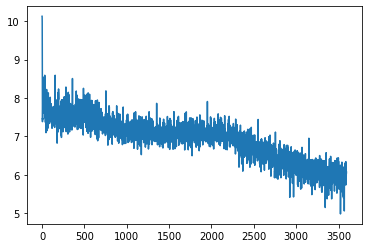

In [17]:
plt.plot(losses)

In [18]:
evaluate(model, test_dl)

Evaluation:   0%|          | 0/71 [00:00<?, ?it/s]

468.0088779333979

![Results on dataset](https://c1.sfdcstatic.com/content/dam/web/en_us/www/images/einstein/publications/wikitext-2.png)

## Generation of text



In [19]:
sentence_start = 'This was a '
print(sentence_start, end=' ')

new_token = None
states = (torch.zeros(lstm_layers, 1, lstm_dim).to(device),
              torch.zeros(lstm_layers, 1, lstm_dim).to(device))
loss_fn = torch.nn.CrossEntropyLoss()
  
while new_token != '<eos>' and len(sentence_start) < 200:
  token_ids = bpemb_en.encode_ids(sentence_start)
  batch = collate_batch_bilstm([{'input_ids': token_ids}])
  logits, states = model(batch[0].to(device), batch[1].to(device), states)
  logits = logits.detach().cpu().numpy()[-1]
  
  new_token_ids = np.argsort(logits, axis=-1)[::-1]
  token_id = new_token_ids[0]
  word = bpemb_en.decode_ids([int(token_id),])
  print(word, end = ' ')
  sentence_start = sentence_start + " " + word

This was a  the first star of of the the 0000 star s . .                                                                                                                                                 

## Check perplexity of a sentence

In [60]:
def get_sentence_perplexity(sentence, model, vocabulary, seq_len):
  states = (torch.zeros(lstm_layers, 1, lstm_dim).to(device),
              torch.zeros(lstm_layers, 1, lstm_dim).to(device))
  token_ids = [{'input_ids': bpemb_en.encode_ids(sentence)}]
  batch = collate_batch_bilstm(token_ids)
  loss_fn = torch.nn.CrossEntropyLoss()
  logits, states = model(batch[0].to(device), batch[1].to(device), states)

  target = batch[2].to(device)[:len(token_ids[0]['input_ids'])-1]
  loss = loss_fn(logits, target.reshape(-1))
  loss = loss.detach().cpu().numpy()
  return np.exp(loss)

In [68]:
get_sentence_perplexity('I want to buy some potatoes from the airport.', model, vocabulary, seq_len)

25002.328

In [67]:
get_sentence_perplexity('jibberish ? . something something is', model, vocabulary, seq_len)

24999.467

References:
- Bucket Iterator https://torchtext.readthedocs.io/en/latest/data.html#bucketiterator
- Packing https://github.com/HarshTrivedi/packing-unpacking-pytorch-minimal-tutorial

# Transformers

## Recap

**Problems with using Bi-LSTMs to learn contextual word embeddings**:
* Recurrent neural networks are difficult to train
  * Vanishing gradients (LSTM; Hochreiter & Schmidhuber 1997)
  * Exploding gradients (norm rescaling; Pascanu et al. 2013)
* Proposal: Transformer Networks
  * Idea 1: Encode words individually with feed-forward neural networks
    * Shorter path for gradient back-propagation
    * Parallel computation possible
  * Idea 2: Replace recurrence function with a positional encoding
    * Fixed-length vectors, similar word embeddings, that represents the position
  * Current base architecture used for all state-of-the-art NLP models


## [Summary of Transformer Models](https://huggingface.co/transformers/model_summary.html)

Apart from improveemnts of the core Transformer architecture, Transformer models differ in the *objectives* they are trained to optimise:

* Decoders/autoregressive models -- pretrained on language modeling task, i.e. predict the next word, given the preceding context. 
* Encoders/autoencoding models -- pretrained to reconstruct corrupted text, i.e. 
* Sequence-to-sequence models -- use both an encoder and a decoder for text-to-text tasks

One architecture can be used for training with different objectives. The used objective makes a model more suitable for particular tasks, e.g., **autoregressive models are most suitable for generation tasks**, while autoencoding models -- for classification tasks, and sequence-to-sequence models for translations, summarisation and other text-to-text tasks.


![LMs](https://imgs.developpaper.com/imgs/4055417039-5e704fdcc441a_articlex.gif)


## Fine-tuning Transformer Models 

We can directly use pretrained Transformer Models (search for suitable models on [HuggingFace's Models page](https://huggingface.co/models)) and fine-tune them to perform our task at hand.

We can also fine-tune the selected Transformer Model with intermediate in-domain data and then use it for the end task.
* Benefit of using unlabelled in-domain data to fine-tune the model with its original objective.
* Especially useful when there is limited labelled data for training the end task.

### Intermediate Fine-tuning with original LM objective and unsupervised data

In [15]:
import transformers
from transformers import AutoTokenizer
from torch.utils.data import Dataset
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import math

In [2]:
model_checkpoint = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

In [34]:
unsupervised_imdb = load_dataset('imdb', split='unsupervised')
unsupervised_imdb_splits = unsupervised_imdb.train_test_split(test_size=0.01)
print(unsupervised_imdb_splits.keys())
print(unsupervised_imdb_splits['train'][0])

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


dict_keys(['train', 'test'])
{'text': 'It looks like everyone here at IMDb is pretty unanimous about this film - it stinks! And, as a movie billed as "family film," it\'s an insult and a bad joke.<br /><br />Yeah, there are some likable characters in here and I would be lying if I didn\'t admit I laughed at a number of gags but I (along with two parents) was embarrassed showing this advertised "kids\' film" to their children, only to hear Jesus\'s name used in vain twice within six minutes and then hear all kinds of sexual innuendos by the little girl in the movie. A little girl once commenting about a guy having a "great butt" and another time asking another if he\'s gay. Come on! Also, you can tag on the normal amount of what it called "bathroom humor." It\'s everywhere here. <br /><br />What the film is, basically, is garbage, despite the baseball angle. I usually enjoy baseball films, but I can\'t classify this as such. Parents: do your homework before watching some of these "famil

In [35]:
block_size = 128
def tokenize_function(examples):
    return tokenizer(examples["text"])

def group_texts(examples):
    # Concatenate all texts.
    keys = ['attention_mask', 'input_ids']
    concatenated_examples = {k: sum(examples[k], []) for k in keys}
    total_length = len(concatenated_examples[list(keys)[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    # this is needed as the used dataset is a subclass of ClassificationDataset, which requires label as a field...
    result["label"] = result["input_ids"].copy()
    result["labels"] = result["input_ids"].copy()
    return result

unsupervised_imdb_tok = unsupervised_imdb_splits.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])
unsupervised_imdb_splits = unsupervised_imdb_splits.remove_columns(['label'])
unsupervised_imdb_tok_lm = unsupervised_imdb_tok.map(group_texts, batched=True, batch_size=1000, num_proc=4,)
unsupervised_imdb_tok_lm = unsupervised_imdb_tok_lm.remove_columns(['label'])
print(unsupervised_imdb_tok_lm['test'][0])

Token indices sequence length is longer than the specified maximum sequence length for this model (1181 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1213 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1110 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1138 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1199 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'input_ids': [64, 1049, 21751, 416, 4186, 15329, 896, 11, 262, 1049, 3437, 12155, 8092, 1766, 381, 5708, 11, 262, 629, 877, 444, 11, 290, 262, 749, 4950, 14549, 287, 262, 995, 1683, 357, 45, 459, 562, 544, 509, 19870, 828, 787, 257, 407, 12, 548, 12, 403, 37850, 1621, 656, 257, 3807, 326, 1276, 3785, 287, 262, 7443, 286, 27151, 13, 317, 1049, 1842, 1621, 13, 40, 760, 867, 1064, 326, 262, 45176, 389, 17185, 290, 257, 1103, 1309, 866, 329, 262, 2656, 2646, 2158, 1312, 1043, 428, 16304, 9623, 0, 383, 11034, 318, 21840, 11, 290, 345, 460, 1560, 612, 373, 257, 3236, 2033, 286, 3626, 656, 1642,

In [36]:
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    "test-clm",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    max_steps=300
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=unsupervised_imdb_tok_lm["train"],
    eval_dataset=unsupervised_imdb_tok_lm["test"],
)

max_steps is given, it will override any value given in num_train_epochs


In [38]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1204
  Batch size = 8


Perplexity: 71.19


In [39]:
trainer.train()

***** Running training *****
  Num examples = 116156
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 300


Epoch,Training Loss,Validation Loss
0,No log,4.056175


***** Running Evaluation *****
  Num examples = 1204
  Batch size = 8




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=300, training_loss=4.178813883463541, metrics={'train_runtime': 130.2876, 'train_samples_per_second': 18.421, 'train_steps_per_second': 2.303, 'total_flos': 78389025177600.0, 'train_loss': 4.178813883463541, 'epoch': 0.02})

In [40]:
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 1204
  Batch size = 8


Perplexity: 57.75


In [41]:
model.save_pretrained("imdb-gpt2")

Configuration saved in imdb-gpt2/config.json
Model weights saved in imdb-gpt2/pytorch_model.bin


### End Domain finetuning for the target classification task.

* The pretrained (and potentially finetuned on an intermediate task) model can be used in multiple ways:
  * Use the learned weights and add a linear layer at the end for classification, e.g. for onne [CLS] token
  * Export the contextual representations of the words and use them in another model or aggregate them in one representation with following layers for classification.

In [59]:
# Export contextual representations:

def mean_pooling(model_output, attention_mask):
    # Mean Pooling - Take attention mask into account for correct averaging
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_output.size()).float()
    sum_embeddings = torch.sum(model_output * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

encoded = tokenizer(['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers".'],
                    return_tensors='pt')
encoded = {k:v.to(device) for k, v in encoded.items()}

model_output = model(**encoded, output_hidden_states=True, return_dict=True)
print(model_output.keys())
print(len(model_output['hidden_states']) # contextual representations of separate words from each of the 6 layes
print(model_output['hidden_states'][-1].shape) # last layer with contextual representations (batch_size x num words x representation dim)

# Aggregate all the representations into one
mean_model_output = mean_pooling(model_output['hidden_states'][-1], encoded['attention_mask'])
mean_model_output.shape

odict_keys(['logits', 'past_key_values', 'hidden_states']) 7 torch.Size([1, 29, 768])


torch.Size([1, 768])

## Generation

In [18]:
model_checkpoint = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/distilgpt2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f985248d2791fcff97732e4ee263617adec1edb5429a2b8421734c6d14e39bee.422318838d1ec4e061efb4ea29671cb2a044e244dc69229682bebd7cacc81631
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.

In [19]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('I was meaning to', return_tensors='pt')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I was meaning to be a part of the world, and I was a part of it. I was a part of it. I was a part of it. I was a part of it. I was a part of it. I was a


## Text Generation Approaches
[Source 1](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb), [Source 2](https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277)

Standard generation 
* **Greedy search** - pick the word with the highest probability as the next word at each time step.
* The model quickly starts to repeat itself.
  * Common problem in language generation (Vijayakumar et. al, 2016)[https://arxiv.org/abs/1610.02424],(Shao et. al, 2017)[https://arxiv.org/abs/1701.03185].
* Misses high probability words hidden behind a low probability word.

![BEAM](https://camo.githubusercontent.com/41e1d5381d477e5fe790c89e75eade680714172f/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f7061747269636b766f6e706c6174656e2f736369656e74696669635f696d616765732f6d61737465722f6265616d5f7365617263682e706e67)


Other generation approaches:
* **Beam Search**
  * Keeps a list of the most likely num_beams so far, the final text is the one with the highes score.
  * Solves the problem of missing high probability words hidden behind a low probability words.
  * Downside: still generates repeating words
  * Downside: works well only in tasks where the length of the generated text is predictable and not variable - e.g. machine translation and summarisation vs. dialogue/story generation

* **N-gram penalty**
  * Reduce probability of next words that will result in n-grams that have been generated already
  * Downside: Not always a desirable effect, some repetiotions might be ok

* **Sampling**
  * Randomly pick the next work from the generated probability distribution
  * Ari Holtzman et al. (2019) note that high quality human language does not follow a distribution of high probability next words
  * Downside: Output is not often incoherent 
  * Use **temperature** to shift the probability distributions
    * Dividing logits by the temperature before feeding them into softmax 

* **Top-K Sampling**
  * [(Fan et al., 2020)](https://arxiv.org/pdf/1805.04833.pdf) 
  * The K most likely next words are filtered and the probability mass is redistributed among only those K next words
  * Used in GPT2 and can be partly attributed to its success
  * Downside: Does not dynamically adapt the number of words 

![top-k-before](https://miro.medium.com/proxy/1*Fa84hdkDEOT02Kz-S5IWuw.png)
![top-k-after](https://miro.medium.com/proxy/1*eGdyEZ_SMa5FH1ElY6Ro7w.png)

* Top-p Nucleus Sampling
  * Instead ot top-k, chooses from the smallest possible set of words whose cumulative probability exceeds the probability p.
  * Appears to improve quality by removing the tail and making it less likely to go off-topic.
  * Dynamic number of words.

In [ ]:
input_ids = tokenizer.encode('I was going', return_tensors='pt')

beam_outputs = model.generate(input_ids, max_length=50, num_beams=5, num_return_sequences=5)
print("Beam Search Output:")
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search Output:
0: I was going to have to do a lot of work to make sure I had enough time to make sure I had enough time to make sure I had enough time to make sure I had enough time to make sure I had enough time to make sure I
1: I was going to have to do a lot of work to make sure I had enough time to make sure I had enough time to do a lot of work to make sure I had enough time to make sure I had enough time to make sure I had
2: I was going to have to do a lot of work to make sure I had enough time to make sure I had enough time to make sure that I had enough time to make sure that I had enough time to make sure that I had enough time to
3: I was going to have to do a lot of work to make sure I had enough time to make sure I had enough time to make sure that I had enough time to make sure I had enough time to make sure I had enough time to make sure
4: I was going to have to do a lot of work to make sure I had enough time to make sure I had enough time to make sure I had enoug

In [ ]:
input_ids = tokenizer.encode('I was going', return_tensors='pt')

output = model.generate(input_ids, max_length=50, num_beams=5)
print("Beam Search Output:")
print(tokenizer.decode(output[0], skip_special_tokens=True))

output = model.generate(input_ids, max_length=50, num_beams=5, no_repeat_ngram_size=2)
print("N-Gram Penalty on Beam Search Output:")
print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Beam Search Output:
I was going to have to do a lot of work to make sure I had enough time to make sure I had enough time to make sure I had enough time to make sure I had enough time to make sure I had enough time to make sure I
N-Gram Penalty on Beam Search Output:
I was going to have to do a lot of work to make sure I had the right amount of time to work on this project.”

“I’m not sure if I can do that, but I think it�


In [ ]:
# Higher temperature -- more random samples, lower -- more deterministic

input_ids = tokenizer.encode('I was going', return_tensors='pt')

greedy_output = model.generate(input_ids, max_length=50, do_sample=True)
print("Sampling Output:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, temperature=10.)
print("Sampling Output:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, temperature=0.5)
print("Sampling Output:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sampling Output:
I was going to do this once and for all. I hope you enjoy this. Please tell me what I think and what you thought. I am too afraid there will be many more years before you do. I hope you love this.
I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sampling Output:
I was going through four great breaks since moving into training when Josh called Ihkane from Oklahoma: he played a perfect three pass attack just like my cousin on TV said about, and also he did every last step in there for those to work
Sampling Output:
I was going to be a big, big, big, big guy, and I needed to be good at what I was doing," he said. "I just wanted to be a little more serious. I needed to be more serious and I needed


In [20]:
input_ids = tokenizer.encode('I was going', return_tensors='pt')

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, top_k=50)
print("Tok-K Sampling:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, top_k=10)
print("Tok-K Sampling:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, top_k=100)
print("Tok-K Sampling:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tok-K Sampling:
I was going to sit in front of me, with my father and dad. He's so old; we could get used to it, because the whole story had become so powerful for him and I couldn't just take these things for granted."



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tok-K Sampling:
I was going to be able to get the game on, and I just wanted people to think of the game and what was happening on the first level.›




"You know what? We were all in the same room
Tok-K Sampling:
I was going to get married and [and] I guess it should have been my day job."
































In [21]:
input_ids = tokenizer.encode('I was going', return_tensors='pt')

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, top_k=0, top_p=0.2)
print("Tok-p Nucleus Sampling:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, top_k=0, top_p=0.92)
print("Tok-p Nucleus Sampling:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

greedy_output = model.generate(input_ids, max_length=50, do_sample=True, top_k=0, top_p=0.99)
print("Tok-p Nucleus Sampling:")
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True, do_sample=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tok-p Nucleus Sampling:
I was going to be a lot more productive than I was. I was going to be a lot more productive than I was. I was going to be a lot more productive than I was. I was going to be a lot more productive than I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tok-p Nucleus Sampling:
I was going into terrible pain," she said. "You are just running out of everything and dealing with that now. If something is going to come out of your mind, that may be where you will go."
Tok-p Nucleus Sampling:
I was going to break the samara on Fifth Avenue to find a way to destroy makeup. I wanted to use a kind of paint from the first, because most U.S. states have rejected themselves as self-abusing. That was actually


# Further reading material:
* [Calculation of perplexity for Transformer models](https://huggingface.co/transformers/perplexity.html)
* [Current state-of-the-art in Language Modeling](http://nlpprogress.com/english/language_modeling.html)
* Language models learn some language specific skills, syntactic grammatical relationships and anaphoric coreference, speech, syntactic chunks, and
roles.[(Manning et al., 2020)](https://www.pnas.org/content/pnas/117/48/30046.full.pdf), [(Rogers et al., 2020)](https://aclanthology.org/2020.tacl-1.54/)